# Predictor de genero musical
Explorando la informacion que proporciona Spotify mediante la API me di cuenta de que no incluia el genero de la cancion, esto me llamo poderosamente la atencion ya proporciona otros datos tan abstractos como la bailabilidad. Sin embargo, es entendible que no proporcione esta informacion ya que es dificil de definir, hay canciones que se encuentran influenciadas por distintos generos y eso hace complicado una determinacion precisa. Ademas, mucha gente no distingue generos, he estado en muchas conversaciones donde la confucion entre cumbia y cuarteto o entre trap y rap se da.

Motivado con esta idea encare este proyecto, vamos a ver si es posible de distinguir entre distintos generos utilizando la informacion proporcionada por la API de spotify y haciendo un poco de scraping de datos.

El proyecto se divide en 3 fases, 

## Paso 1: Recopilación de Datos
    Buscando crear un dataset con valores devueltos de la API de Spotify, etiquetando por atistias conocido y que se dedican esclusivamente a un genero. Por ejemplo "La Mona Jimenez" es un referente del cuarteto y es el único genero al cual se dedica. Y ademas, mediante scraping web se obtuvieron las letras de las canciones a las cuales se les aplico un sentimental analysis para determinar el promedio de positividad de cada una de sus frases, para asi obtener un nuevo feature.
    Por su puesto, con toda esta informacion en bruto se prepararon los datos, limpiando algunos registros que habian quedado nulos, entre otras acciones, para un correcto analisis y visualizacion de datos.

## Paso 2: Visualizacion de datos

## Paso 3: Entrenamiento del modelo de clasificación
    Se entreno un modelo de regresion logistica inicialmente para clasificar entre los datos obtenidos. Ademas se obtuvo la correspondiente matriz de confucion, se realizo la correspondiente optimizacion de hiperparametros y se grafico la curva ROE que permite observar el desempeño de este modelo.
    Ademas, se evaluaron otros modelos de clasificacion.
 


# Creación del dataset:
Recopilación de datos:
    Inicialmente se utiliza la API de Spotify para recopilar datos sobre las características de las canciones.

Pero primero, se importan las librerias que se utilizaran en todo el proyecto.
Ademas, como se va a trabajar con la api de spotify se deben cargar las credenciales para posteriormente realizar las requests correspondientes. Las credenciales las paso por el archivo "config.ini" para que no queden definidas en el notebook.

In [5]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from numpy.random import shuffle 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sentiment_analysis_spanish import sentiment_analysis # Supervised Machine Learning Based Aproach
import re
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

# Spotify API credentials
client_id = '3fc2f3c071d8480b96aa379242a07502'#config.get('spotify','client_id')
client_secret = 'b838c1a11677441eb4a633bda27b9873'#config.get('spotify','client_secret')

# Spotify API init
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Ahora, defino algunas funciones para hacer estas request de manera mas automatizada. Cada una tiene sus respectivos comentarios de como funciona pero a groso modo el metodo "get_artist_info" retorna un diccionario con el ID del artista, de sus albunes, generos y el id de sus canciones. Con las ids de las canciones vamos a poder hacer, mediante "get_track_features", las request de la informacion de cada cancion para la elaboracion de este dataframe.

In [ ]:
def get_artist_info(artist_name):
    """
    This function takes an artist name as input and returns a dictionary containing the artist's ID and genre (if available).

    Args:
        artist_name (str): The name of the artist to search for.

    Returns:
        dict: A dictionary containing the artist's ID and genre (or None if not found).
    """
    try:
        search_results = sp.search(q=artist_name, type='artist')
        artists = search_results['artists']['items']

        if artists:
            artist_info = artists[0]  
            artist_id = artist_info['id']
            genres = artist_info.get('genres', [])  
            albums_results = sp.artist_albums(artist_id)
            album_ids = [album['id'] for album in albums_results['items']]

            album_tracks = {}
            total_tracks = []  

            # Loop through each album ID
            for album_id in album_ids:
                # Get album tracks (limit to 50 tracks per request)
                tracks_results = sp.album_tracks(album_id, limit=50)
                tracks = tracks_results['items']

                while tracks_results['next']:
                    tracks_results = sp.next(tracks_results)
                    tracks.extend(tracks_results['items'])
                    
                album_tracks[album_id] = [track['id'] for track in tracks]
                total_tracks.extend(album_tracks[album_id])

            return {
                'artist_id': artist_id,
                'genres': genres,
                'album_ids': album_ids,
                'album_tracks': album_tracks,
                'total_tracks': total_tracks
            }
    
    except:
        print(f"Error al hacer la solicitud de info de artista en la API de Spotify")
        return None

print(get_artist_info("babasonicos")) # A modo de ejemplo imprimo el return de Babass

In [62]:
def get_track_features(track_id):
    """
    This function takes track id as input and returns a dictionary with track info.

    Args:
        track_id (str): The ID of the track search for.

    Returns:
        dict: A dictionary containing the features and attributes of the track.
    """
    try:
        track_info = sp.track(track_id)
        features = sp.audio_features(track_id)[0]
    
        return {
            'track_id': track_info['id'],
            'track_name': track_info['name'],
            'artist_name': track_info['artists'][0]['name'],
            'popularity': track_info['popularity'],
            'danceability': features['danceability'],
            'energy': features['energy'],
            'key': features['key'],
            'loudness': features['loudness'],
            'mode': features['mode'],
            'speechiness': features['speechiness'],
            'acousticness': features['acousticness'],
            'instrumentalness': features['instrumentalness'],
            'liveness': features['liveness'],
            'valence': features['valence'],
            'tempo': features['tempo'],
            'duration_seg' : features['duration_ms']/1000
        }
    except:
        print(f"Error when requesting track information in Spotify API")
        return None


In [ ]:

def create_dataframe(artist_names):
    """
    This function takes a list of artist names and returns a DataFrame containing combined track features for all artists.

    Args:
        artist_names (list): A list containing names of artists to search for.

    Returns:
        DataFrame: A DataFrame containing combined track features.
    """

    # Initialize an empty DataFrame to store combined results
    df = pd.DataFrame()

    # Loop through each artist name
    for artist_name in artist_names:
        artist_data = get_artist_info(artist_name)  # Get artist information

        # Extract track IDs and features
        tracks_data = [get_track_features(track_id) for track_id in artist_data['total_tracks']]

        # Create a temporary DataFrame for this artist's tracks
        artist_df = pd.DataFrame(tracks_data)

        # # Add a 'genre' column and fill with the first genre (assuming single genre)
        # artist_df['genre'] = 0
        # artist_df['genre'].fillna(artist_data['genres'][0], inplace=True)  # Assuming first artist's genre

        # Concatenate the artist's DataFrame to the combined DataFrame
        df = pd.concat([df, artist_df], ignore_index=True)  # Avoid duplicate indices

        #To delete the infiltrators artist
        # unwanted_artist = df[~df["artist_name"].isin(artist_names)].index
        # df.drop(unwanted_artist, inplace=True)

    return df

# Call the function after retrieving artist 
#"Trueno","Airbag","Duki","Callejeros","Acru","Ciro y los Persas","YSY A","Frescolate"
#"La Mona Jimenez","Damas Gratis","Nestor en Bloque","Nene malo","Los Palmeras","Ulises Bueno","Luck Ra","la K'onga",""
artist_names = ["Los Pibes Chorros"]
df = create_dataframe(artist_names)


In [ ]:
df['artist_name'].value_counts()

In [ ]:
unwanted_artist = df[~df["artist_name"].isin(artist_names)].index
df.drop(unwanted_artist, inplace=True)

df['artist_name'].value_counts()

Como los artistas estan siendo elegidos por mi, teniendo en cuenta lo que coincidero artistas representantes especificamente de su genero, designo el tag de genero de esta forma. Tambien se puede hacer de manera automatica con el genero de cada artista que nos devuelve la API, pero en multiples casos este valor no estaba bien designado o era nulo, por eso decidi hacerlo de manera manual. 

In [ ]:
# Genre. 0 = Cuarteto ; 1 = Cumbia
df['genre'] = 1
# indice =  df['artist_name'] == artist_names  
# df.loc[indice, 'genre'] = 1

df['genre'].value_counts()

Ahora solo falta juntar esta nueva informacion con la info de otros artistas ya analisados, para ello guardo los valores en 'data.csv'

In [ ]:
df_old = pd.read_csv('data.csv')
# Add the new artist into the original DataFrame
df_new = pd.concat([df_old, df], ignore_index=True)

# Save the DataFrame into 'data.csv'
df_new.to_csv('data.csv', index=False)


# Nueva Feature

En este punto ya se creo el dataset, se guardo artista por artista en el .csv. Pero resultaria interesante agregar una entrada mas, que hable un poco de la letra de estas canciones. Ya que al fin y al cabo las features obtenidas de spotify habla en general de la musica pero no del contenido de la letra en si mismo.

Para esto se realizara un analisis sentimental de cada letra, lo primero es leer el dataset y quiero ver que los registros esten balanceados.

In [6]:
df_spotify = pd.read_csv('data.csv')
df_spotify['genre'].value_counts()


genre
0    1041
1     904
Name: count, dtype: int64

Lo primero que voy a necesitar es la letra de cada cansion, spotify no me provee de esta info asi que ya no voy a poder recurrir a la API. 

No queda otra que aventurarse en las oscuras artes del scraping, la pagina letras.com parece ser ideal para esto.

Utilizando BeautifulSoup e inspeccionando un poco el html de la pagina logro crear la funcion "obtener_letra" que me devuelve la letra de cada una de las canciones.

In [63]:
import requests
from bs4 import BeautifulSoup

def obtener_letra(artista, titulo):
  """
  Función para obtener la letra de una canción en Letras.com.

  Args:
    artista: Nombre del artista.
    titulo: Título de la canción.

  Returns:
    La letra de la canción como string, o None si no se encuentra.
  """
  artista = artista.lower().replace(" ","-")
  # titulo = re.sub(r"\s*\(.*?\)\s*", "", titulo)
  titulo = re.sub(r"[\(\[].*?[\)\]]", "", titulo)
  titulo = re.sub(r"/.*", "", titulo)
  titulo = titulo.lower().replace(" ","-")


  url = f"https://www.letras.com/{artista}/{titulo}"
  response = requests.get(url)

  if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    letra_div = soup.find('div', class_ = "lyric-original font --lyrics --size18")

    if letra_div:
      return letra_div.text.strip()
    else:
      return None
  else:
    print(f"Error al acceder a la URL: {url}")
    return None

# Ejemplo de uso
artista = "damas-gratis"
titulo = "sos-boton"

letra = obtener_letra(artista, titulo)

if letra:
  print(f"Letra de {titulo} de {artista}:\n{letra}")
else:
  print(f"No se encontró la letra de {titulo} de {artista}")

Letra de sos-boton de damas-gratis:
¡Sufre, por hacerte el policia!¡No!, no lo puedo creerVos ya no sos el vagoYa no sos el atorranteAl que los pibes lo llamaban el picanteAhora te llaman botonYa no estásCon tus amigosY en la esquina te la dabasDe polenta, de malevo y de matonY solo eras un botonY solo eras un botonVos sos un botonNunca vi a un policiaTan amargo como vosVos sos un botonNunca vi a un policiaTan amargo como vos¡Damas gratis, wipi!Para vos, CarlitosCuando ibas a la canchaParabas con la hinchadaY tomabas vino blancoY ahora patrullas la ciudadSi vas a la cancha vas con celularY a tus amigosAndas arrestandoSos el policia del comandoVos sos un botonNunca vi a un policiaTan amargo como vosVos sos un botonNunca vi a un policiaTan amargo como vosVos sos un botonNunca vi a un policiaTan amargo como vosVos sos un botonNunca vi a un policiaTan amargo como vos


La letra que nos provee letras.com tiene algunos problemas de formato, para esto creo el metodo "agregar_espacios" asi la acomodamos un poco

In [ ]:
def agregar_espacios(texto):
  """
  Función para agregar espacios antes de mayúsculas en un texto usando expresiones regulares.

  Args:
    texto: El texto original.

  Returns:
    El texto con espacios agregados antes de mayúsculas.
  """
  if texto:
    return re.sub(r"([a-z])([A-Z])", r"\1. \2", texto)
  else:
    return None

El metodo "sentimental_coeficient" implementa el objeto sentiment_analysis y obtiene el valor de "positividad" de cada una de las frases de la cancion para luego promediarlas y lograr un valor general de positividad del track.

In [ ]:
def sentimental_coeficient(letra):
    """
    Funcion que retorna el valor de sentimiento obtenido del promedio en las frases de la 
    Args: 
        letra: Letra de la cansion

    Returns:
        La media de los sentimientos donde 1 es alegría y 0 tristeza
    """
    if letra:
        letra = agregar_espacios(letra)
        sentimental = sentiment_analysis.SentimentAnalysisSpanish() # Inicializamos el objeto
        sentimental_coef = np.array([sentimental.sentiment(f) for f in letra.split('.')])
        sentimental_mean = np.mean(sentimental_coef) 
        if sentimental_mean:
            return sentimental_mean
        else:
            return 0
    else :
        return 0

Solo falta recorrer todas las canciones en el dataset y añadir a cada registro la "positividad"

In [ ]:
for index, row in df_spotify.iterrows():
    if df_spotify["positividad"][index] == 0:
        print(row["track_name"])
        track_name = re.split(r" - ",row["track_name"])[0]
        print(track_name)
        if "!" in track_name:
            df_spotify.drop(index, inplace = True)
        else:    
            letra = obtener_letra(row["artist_name"],track_name)
            letra = agregar_espacios(letra)
            print(index)
            df_spotify.loc[index,"positividad"] = sentimental_coeficient(letra)
            print(df_spotify["positividad"][index])

# Logistic regression

In [70]:
def balanced_accuracy(cm):
  """
  Returns the metrics of the model
  """
  sensitivity = cm[1,1]/(cm[1,1]+cm[0,1])
  specificity = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensitivity, specificity, (sensitivity + specificity)/2]

In [76]:
# Define the feature matrix X
fields = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_seg','positividad'] 
X = df_spotify[fields].values 
y = df_spotify['genre'] 
print(X.shape) 

scaler = MinMaxScaler() # maping of feature with MinMaxScaler. By default, this function map the values into [0,1]
scaler.fit(X) # maping paramiters
X = scaler.transform(X) 

regLog = LogisticRegression(penalty = None, class_weight='balanced', max_iter=10000) # Init the model with 10000 iterations

regLog.fit(X, y) # Select the parameters to fit the model
score = regLog.score(X,y) # Get the score of this model

ypred = regLog.predict(X) # get the prediction of the model with the features
cm = confusion_matrix(ypred, y) # do the confusion matrix with ypred and true y
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Print the score of the model
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

(1945, 13)
El score del modelo es de: 0.8062
Matriz de confusion del modelo es:
[[858 194]
 [183 710]]
Sensibilidad del modelo es de: 0.7854
Especificidad del modelo es de: 0.8242
BA del modelo es de: 0.8048


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_train) # encuentro los parametros para el escaleo
X_train = scaler.transform(X_train) # aplico la transformacion

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_test) # encuentro los parametros para el escaleo
X_test = scaler.transform(X_test) # aplico la transformacion

#### IMPORTANTE: HAGO LA NORMALIZACION DE LOS DATOS POR SEPARADO EN LOS SETS DE TRAIN Y TEST

regLog = LogisticRegression(penalty = None, class_weight='balanced', max_iter=10000) # Inicializamos nuevamente el modelo
regLog.fit(X_train, y_train) # Ajustamos el modelo con los parámetros

score_train = regLog.score(X_train,y_train) # Calculamos el score
ypred_train = regLog.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_train = balanced_accuracy(cm_train)

print('Para TRAIN set:')
print('El score del modelo es de: {}'.format(round(score_train,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_train)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_train[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas_train[1],4)))
print('BA del modelo es de: {}'.format(round(metricas_train[2],4)))
print('\n')

score_test= regLog.score(X_test,y_test) # Calculamos el score
ypred_test= regLog.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_test = confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_test = balanced_accuracy(cm_test)


print('Para TEST set:')
print('El score del modelo es de: {}'.format(round(score_test,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_test)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_test[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas_test[1],4)))
print('BA del modelo es de: {}'.format(round(metricas_test[2],4)))

Para TRAIN set:
El score del modelo es de: 0.806
Matriz de confusion del modelo es:
[[589 136]
 [128 508]]
Sensibilidad del modelo es de: 0.7888
Especificidad del modelo es de: 0.8215
BA del modelo es de: 0.8051


Para TEST set:
El score del modelo es de: 0.8014
Matriz de confusion del modelo es:
[[268  60]
 [ 56 200]]
Sensibilidad del modelo es de: 0.7692
Especificidad del modelo es de: 0.8272
BA del modelo es de: 0.7982


# Optimización de hiperparámetros

Vimos que al sumar regularización, la performance del modelo de repente se ve incrementada en el test set. Posiblemente esto dependa del valor de la constante de penalización C que usamos para la regresión. **Esto es lo que llamamos un hiperparámetro del modelo.** Otro hiperparámetro posible es el grado de la potencia máxima en la que aparecen los features.

Entonces tiene sentido hacer la siguiente pregunta: ¿para qué elección de hiperparámetros **maximizo** la performance del clasificador en el dataset de evaluación (test)?

Vamos a proponer la siguiente forma de abordar este problema:

1.   Generamos una función que entrene y evalue el clasificador usando un train-test split, que incorpore como input los hiperparámetros
2.   Para cada elección del par de hiperparámetros, repetimos este procedimiento unas cuantas (>100) veces y nos quedamos con la performance promedio. Esto es necesario porque el train-test split es aleatorio.
3.   Repetimos para todas las combinaciones de nuestros hiperparámetros y encontramos aquella que maximiza la performance del clasificador.

In [1]:
def classifier(X,y,n,c):  # X es la matriz de features, y los labels, n-1 la potencia máxima en la que aparecerán los features, C es la constante de regularización

  X_temp = X
  for i in np.arange(2,n):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
  X = X_temp


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_train) # encuentro los parametros para el escaleo
  X_train = scaler.transform(X_train) # aplico la transformacion

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_test) # encuentro los parametros para el escaleo
  X_test = scaler.transform(X_test) # aplico la transformacion

  regLog = LogisticRegression(penalty = 'l2', class_weight='balanced', C=c, max_iter=10000)
  # regLog = MLPClassifier(alpha=1, max_iter=1000)
  
  regLog.fit(X_train, y_train)

  ypred_train = regLog.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_train = balanced_accuracy(cm_train)

  ypred_test = regLog.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_test= confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_test = balanced_accuracy(cm_test)

  return metricas_train[2], metricas_test[2]

In [ ]:
# Definamos la matriz X
campos = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_seg','positividad'] # Lista que contiene las features de interés
X = df_spotify[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = df_spotify['genre'] # Nuestra etiqueta sigue siende la misma de antes
print(X.shape) 


BA_train, BA_test = classifier(X,y,6,1)
print(BA_train, BA_test)

# aumento C

BA_train, BA_test = classifier(X,y,6,1000)
print(BA_train, BA_test)

# disminuyo C

BA_train, BA_test = classifier(X,y,6,0.0001)
print(BA_train, BA_test)

In [35]:
n_values = np.arange(1,6) # rango de potencias maximas
c_values = np.arange(0.2,5,0.2) # rango de constantes de regularizacion

iterations = 100 # esto se puede poner en 100 para que no tarde mil años durante la clase

mean_BA_train = np.zeros((len(n_values),len(c_values))) #  los arrays con los balanced accuracy para cada combinacion de hiperparametros, para train y test
mean_BA_test = np.zeros((len(n_values),len(c_values)))

for xx,n in enumerate(n_values): # itero sobre n
    for yy,c in enumerate(c_values): # itero sobre c
      BA_test_temp = [] # variables temporales para ir poniendo los resultados a lo largo de las iteraciones
      BA_train_temp = []
      print([n,c]) # esto es para los ansiosos
      for it in np.arange(iterations): # itero
          BA_train, BA_test = classifier(X,y,n,c)  # calculo las balanced accuracy para esos hiperparametros
          BA_test_temp.append(BA_test) # agrego a las variables temporales
          BA_train_temp.append(BA_train)
      mean_BA_train[xx,yy] = np.mean(BA_train_temp) # calculo promedios
      mean_BA_test[xx,yy] = np.mean(BA_test_temp)

[1, 0.2]
[1, 0.4]
[1, 0.6000000000000001]
[1, 0.8]
[1, 1.0]
[1, 1.2]
[1, 1.4000000000000001]
[1, 1.6]
[1, 1.8]
[1, 2.0]
[1, 2.2]
[1, 2.4000000000000004]
[1, 2.6000000000000005]
[1, 2.8000000000000003]
[1, 3.0000000000000004]
[1, 3.2]
[1, 3.4000000000000004]
[1, 3.6000000000000005]
[1, 3.8000000000000003]
[1, 4.0]
[1, 4.2]
[1, 4.4]
[1, 4.6000000000000005]
[1, 4.800000000000001]
[2, 0.2]
[2, 0.4]
[2, 0.6000000000000001]
[2, 0.8]
[2, 1.0]
[2, 1.2]
[2, 1.4000000000000001]
[2, 1.6]
[2, 1.8]
[2, 2.0]
[2, 2.2]
[2, 2.4000000000000004]
[2, 2.6000000000000005]
[2, 2.8000000000000003]
[2, 3.0000000000000004]
[2, 3.2]
[2, 3.4000000000000004]
[2, 3.6000000000000005]
[2, 3.8000000000000003]
[2, 4.0]
[2, 4.2]
[2, 4.4]
[2, 4.6000000000000005]
[2, 4.800000000000001]
[3, 0.2]
[3, 0.4]
[3, 0.6000000000000001]
[3, 0.8]
[3, 1.0]
[3, 1.2]
[3, 1.4000000000000001]
[3, 1.6]
[3, 1.8]
[3, 2.0]
[3, 2.2]
[3, 2.4000000000000004]
[3, 2.6000000000000005]
[3, 2.8000000000000003]
[3, 3.0000000000000004]
[3, 3.2]
[3, 3.

Por último, grafico como me quedan las BA para cada combinación de hiperparametros, y puedo encontrar cual es la BA máxima para cada caso, y con qué hiperparámetros la obtengo.

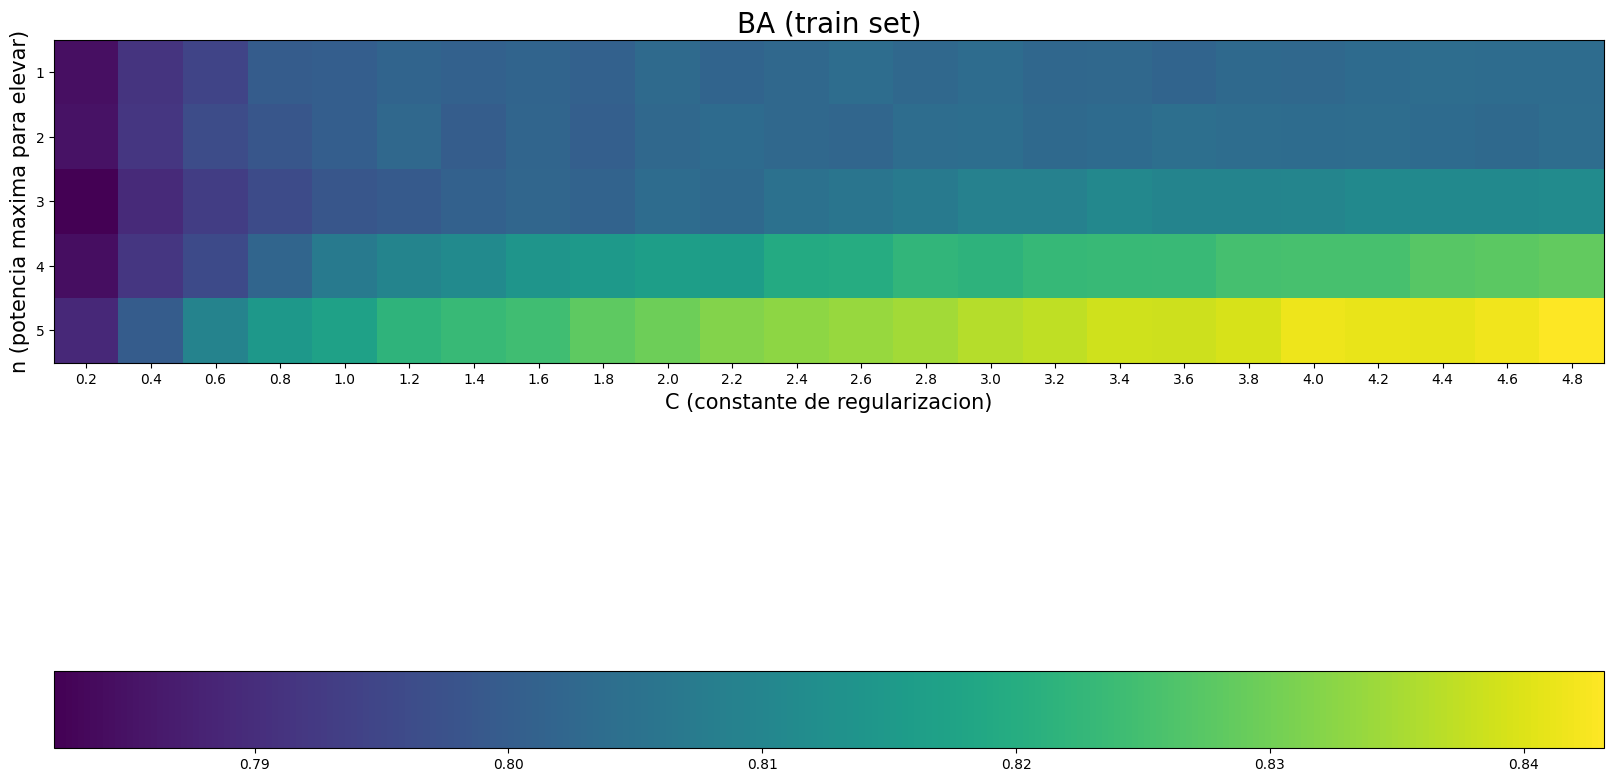

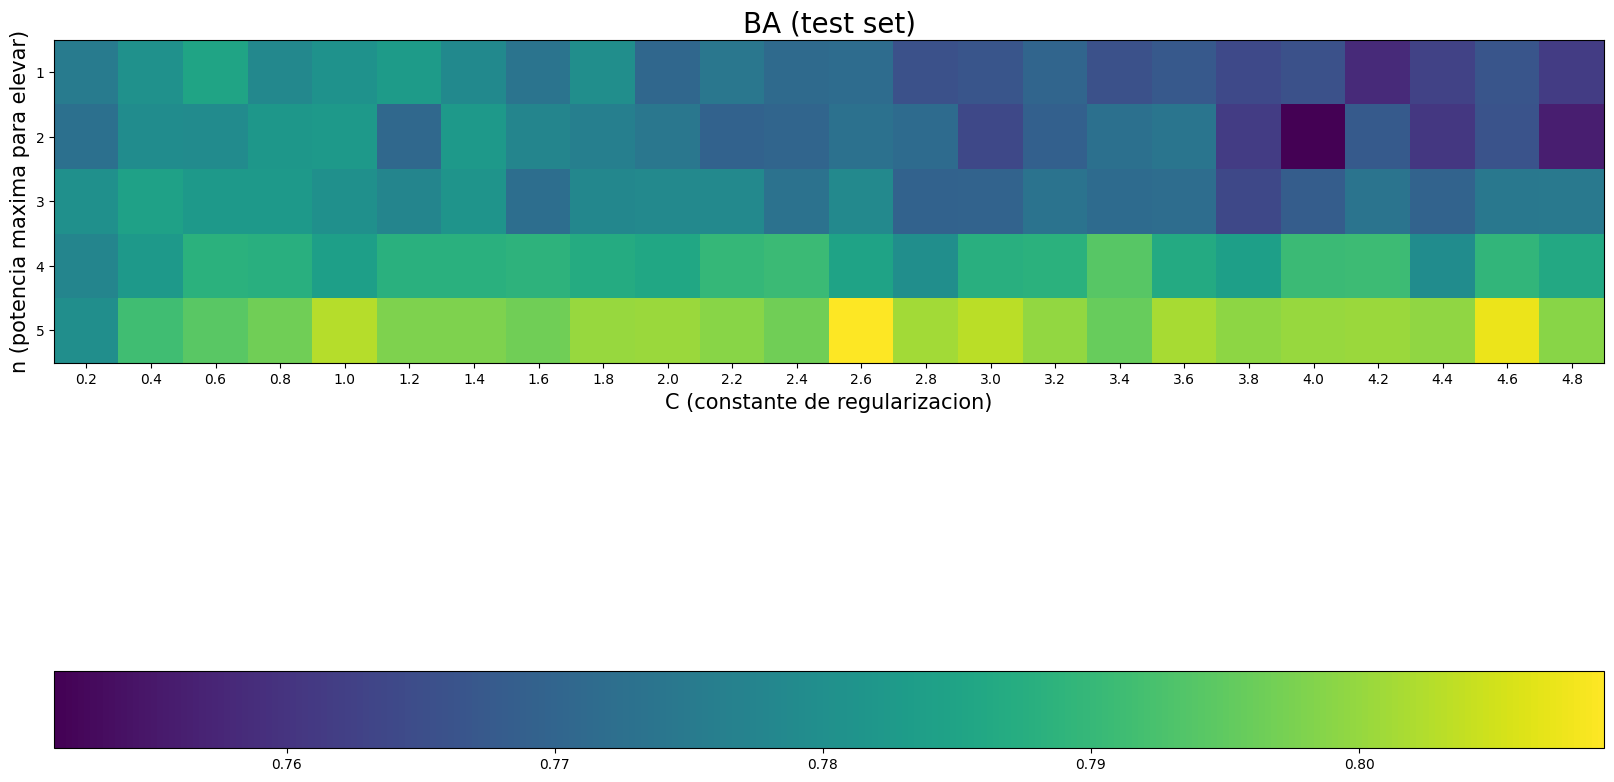

In [36]:
fig, ax = plt.subplots(1,1, figsize=(20,20))  # visualizacion train set
img = ax.imshow(mean_BA_train) # graficamos la matriz
y_label_list = n_values # estos son los ticks de los ejes
x_label_list = [round(value, 7) for value in c_values]
ax.set_xticks(np.arange(len(c_values))) # creo los ticks de los ejes
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list) # pongo los ticks de los ejes
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15) # le pongo nombre a ejes y titulo
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (train set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2) # la barra de colores donde no me moleste

fig, ax = plt.subplots(1,1, figsize=(20,20)) # visualizacion test set, ver comentarios para el caso train, es idéntico
img = ax.imshow(mean_BA_test)
y_label_list = n_values
x_label_list = [round(value, 7) for value in c_values]
ax.set_xticks(np.arange(len(c_values)))
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15)
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (test set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2)


In [37]:
BA_train, BA_test = classifier(X,y,5,2.6)
print(BA_train, BA_test)

0.8419288880022897 0.7881591228629827


# Modelo nulo y curva ROC

Supongamos que queremos construir un modelo que sepamos es incapaz de clasificar los datos por encima del nivel azar. Una forma de hacer esto es randomizando (shuffleando) las etiquetas. Si permutamos las etiquetas al azar, entonces rompemos la relación entre features y targets, y podemos asumir que no hay nada útil que el clasificador pueda aprender, de forma tal que el AUC de este modelo nos da una buena idea de lo que podemos obtener al nivel chance.

Veamos cómo se ve el ROC plot para datos con y sin randomización de labels.

In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = None, max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores = np.concatenate((scores,probas_test[:,1]),axis=0)
    indices = np.concatenate((indices,test_index),axis=0)
    targets = np.concatenate((targets,y_test),axis=0)

print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))

Estos son los valores AUC para cada fold:
[0.8743221690590112, 0.8654377390565235, 0.8942042073948151, 0.8610284742881428, 0.8752124946876328]
Estos es el promedio de todos los AUC:
0.874041016897225


Y ahora voy a todo pero permutando aleatoriamente todos los targets antes de empezar.

In [39]:
y_shuffled = y.copy() # creo una copia del vector de targets, porque shuffle lo pisa
shuffle(y_shuffled) # shuffleo

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y_shuffled) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores_shuffled = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices_shuffled = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets_shuffled = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y_shuffled): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y_shuffled[train_index], y_shuffled[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = None, max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores_shuffled  = np.concatenate((scores_shuffled ,probas_test[:,1]),axis=0)
    indices_shuffled  = np.concatenate((indices_shuffled ,test_index),axis=0)
    targets_shuffled  = np.concatenate((targets_shuffled ,y_test),axis=0)



print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))

C:\Users\bruno\AppData\Local\Temp\ipykernel_1580\3815737450.py:2: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  shuffle(y_shuffled) # shuffleo


Estos son los valores AUC para cada fold:
[0.5134502923976608, 0.4816457713557162, 0.5023108797280068, 0.5174644071398216, 0.4889635571610709]
Estos es el promedio de todos los AUC:
0.5007669815564553


Ahora vamos a plotear las dos curvas ROC juntas para ver como se ven:

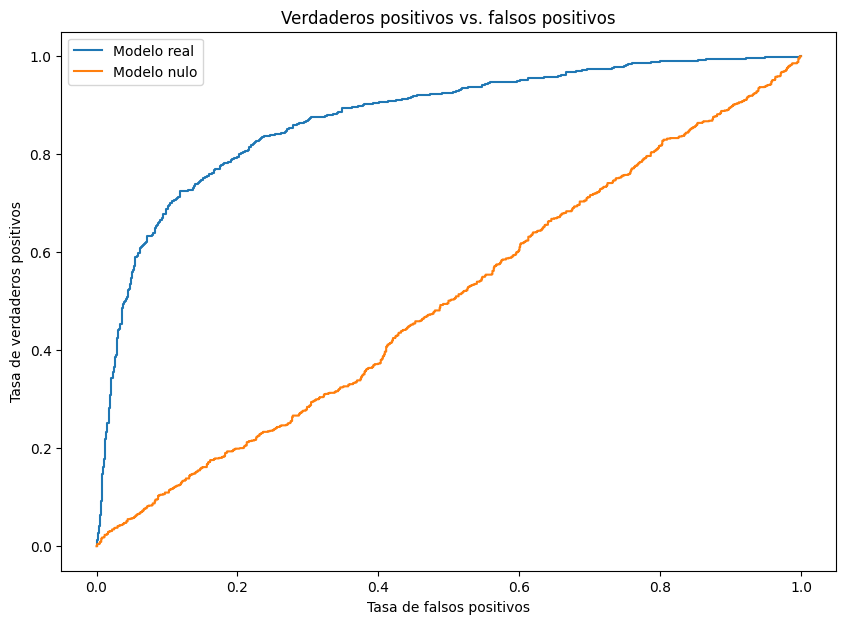

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# este codigo fue sacado del notebook de ROC AUC (clase 10) y sirve para visualizar la curva ROC

fpr, tpr, thresholds = roc_curve(targets, scores)
fpr_shuffled, tpr_shuffled, thresholds_shuffled = roc_curve(targets_shuffled, scores_shuffled)

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr,tpr, label='Modelo real')
ax.plot(fpr_shuffled,tpr_shuffled, label='Modelo nulo')

ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y
plt.legend()

AUC entrenamiento: 0.9425
AUC evaluacion: 0.9235


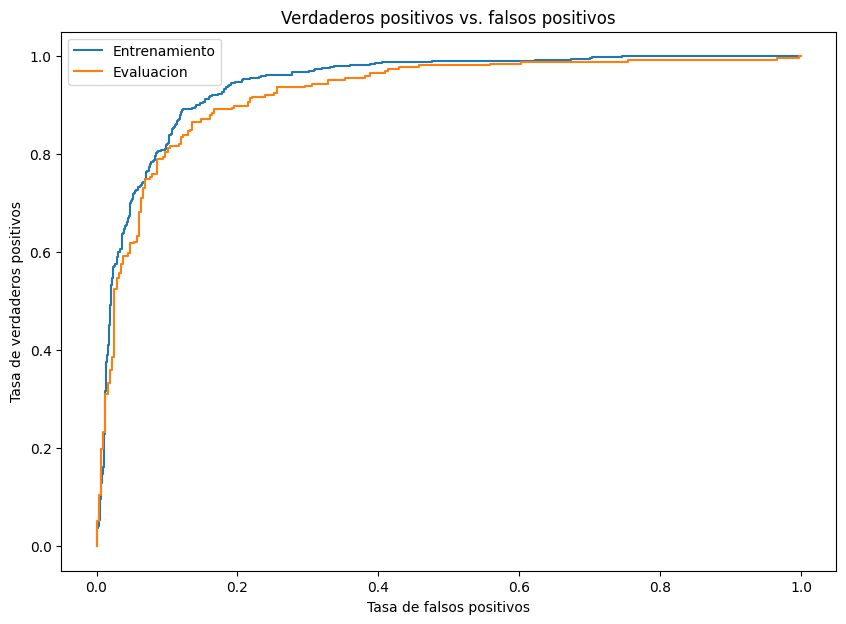

In [41]:
X_temp = X
for i in np.arange(2,6):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
X_1 = X_temp


X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.3) # armo el split

scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_train)
X_train = scaler.transform(X_train)

scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_test)
X_test = scaler.transform(X_test)

regLog_1 = LogisticRegression(penalty = None, max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

probas_train = regLog_1.predict_proba(X_train)  # probabilidades con datos de entrenamiento
probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, probas_train[:,1]) # para plotear curva ROC con datos de entrenamiento
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de evaluacion

auc_train = roc_auc_score(y_train, probas_train[:,1]) #  AUC con datos de entrenamiento
auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

# para plotear ROC (codigo de un notebook anterior)

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr_train,tpr_train, label = "Entrenamiento") # graficamos la curva ROC para el set de entrenamiento
ax.plot(fpr_test,tpr_test, label = "Evaluacion") # graficamos la curva ROC para el set de evaluacion

ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

plt.legend()

print('AUC entrenamiento: {}'.format(round(auc_train,4)))
print('AUC evaluacion: {}'.format(round(auc_test,4)))

In [40]:
X_temp = X
for i in np.arange(2,6):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
X_1 = X_temp


skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X_1, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores

for train_index, test_index in skf.split(X_1, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X_1[train_index], X_1[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = None, max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores = np.concatenate((scores,probas_test[:,1]),axis=0)
    indices = np.concatenate((indices,test_index),axis=0)

print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))
print("Estos son las probabilidades para cada sample:")
print(scores)
print("Esta es la forma en que quedaron ordenados las entradas del vector anterior (indices):")
print(indices)

Estos son los valores AUC para cada fold:
[0.7839712918660287, 0.8775233744156397, 0.8632065448363792, 0.8742562685932852, 0.8540427114322142]
Estos es el promedio de todos los AUC:
0.8506000382287094
Estos son las probabilidades para cada sample:
[2.25336558e-01 9.32739404e-21 2.31531355e-01 ... 4.37274529e-01
 4.30743489e-01 4.30489788e-01]
Esta es la forma en que quedaron ordenados las entradas del vector anterior (indices):
[   2.   12.   26. ... 1937. 1939. 1941.]


In [4]:
# librerías básicas
import numpy as np
import matplotlib.pyplot as plt
# para crear un colormap basado en colores
from matplotlib.colors import ListedColormap
# selección de modelos
from sklearn.model_selection import train_test_split
# normalización de datos
from sklearn.preprocessing import StandardScaler
# funciones para construir datasets sintéticos
from sklearn.datasets import make_moons, make_circles, make_classification
# clasificador: red neuronal (perceptron multicapa, 100 capas por defecto, activación por ReLu)
from sklearn.neural_network import MLPClassifier
# clasificador: KNN
from sklearn.neighbors import KNeighborsClassifier
# clasificador: support vector classifier
from sklearn.svm import SVC
# clasificador: árbol de decisión
from sklearn.tree import DecisionTreeClassifier
# clasificador: ensemble de árboles (random forest)
from sklearn.ensemble import RandomForestClassifier

In [42]:
names = ["KNN", "SVM lineal", "SVM RBF", "Árbol de decisión", "Random Forest", "Red neuronal"]

classifiers = [
    KNeighborsClassifier(7),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    ]

<Figure size 2000x800 with 0 Axes>

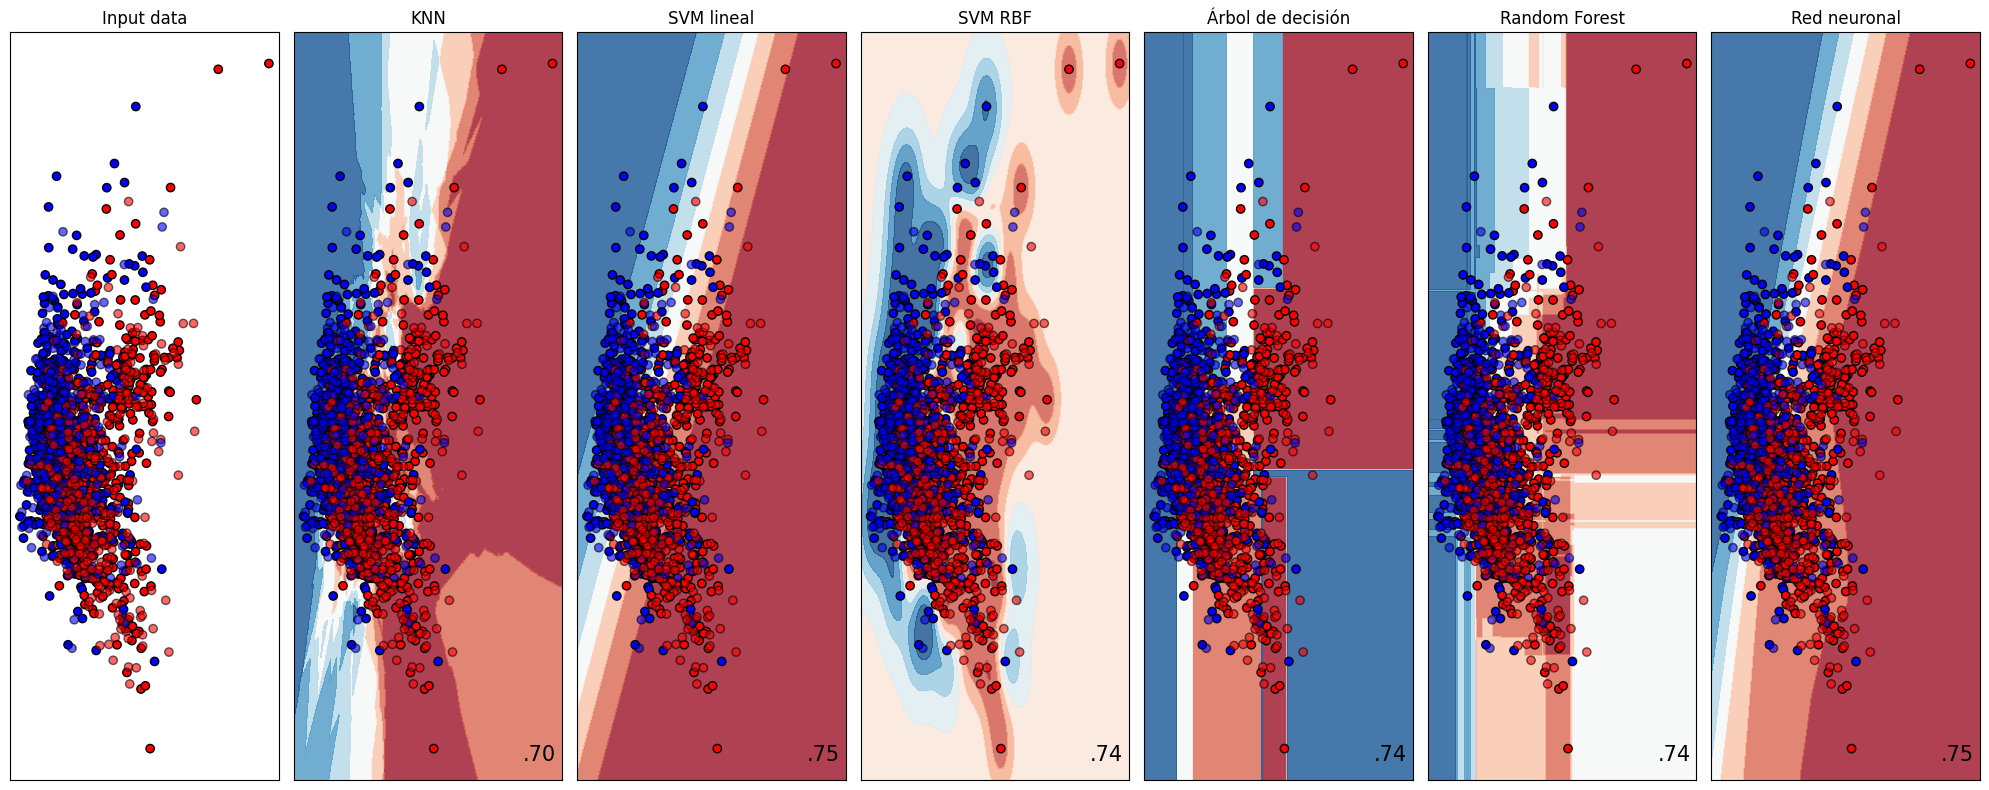

In [62]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Ejemplo de configuración de datos
# df_spotify = pd.read_csv("your_data.csv") # Cargar tus datos aquí

# Definamos la matriz X
campos = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_seg','positividad'] # Lista que contiene las features de interés
X = df_spotify[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = df_spotify['genre'] # Nuestra etiqueta sigue siende la misma de antes

# Escalar los datos
X = StandardScaler().fit_transform(X) 

# Reducir dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.4, random_state=42) 

# Configurar la figura
figure = plt.figure(figsize=(20, 8)) 
h = 0.02 # el paso de la grilla

x_min, x_max = X_pca[:, 0].min() - .5, X_pca[:, 0].max() + .5 # defino el rango de ejes x
y_min, y_max = X_pca[:, 1].min() - .5, X_pca[:, 1].max() + .5 # defino el rango de ejes y
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h)) # construyo una mella de puntos en ese rango

cm = plt.cm.RdBu # esto seleccion el tipo de color map (rojo-azul)
cm_bright = ListedColormap(['#FF0000', '#0000FF']) # construye el colormap entre esos dos colores

# Definir los clasificadores
names = ["KNN", "SVM lineal", "SVM RBF", "Árbol de decisión", "Random Forest", "Red neuronal"]
classifiers = [
    KNeighborsClassifier(7),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
]

# Crear una cuadrícula de subplots
fig, axes = plt.subplots(1, len(classifiers) + 1, figsize=(20, 8))

# Primer subplot: datos de entrada
ax = axes[0]
ax.set_title("Input data") 
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k') # plotea datos de entrenamiento
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k') # plotea datos de evaluacion
ax.set_xlim(xx.min(), xx.max()) # pone limites
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

for k, (name, clf) in enumerate(zip(names, classifiers)):
    clf.fit(X_train, y_train) # entreno
    score = clf.score(X_test, y_test) # evaluo

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] # predice las probabilidades sobre cada par de puntos de la grilla
    Z = Z.reshape(xx.shape) # le da el formato adecuado para plotear el mapa de colores

    ax = axes[k + 1]
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8) # plotea el mapa de colores

    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k') # plotea puntos de entrenamiento
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6) # plotea puntos de evaluacion

    ax.set_xlim(xx.min(), xx.max()) # rango en x
    ax.set_ylim(yy.min(), yy.max()) # rango en y
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name) # pone titulo
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')

plt.tight_layout()
plt.show()

# Clustering (BORRADOR)

 

In [ ]:
# importamos las librerías usuales de python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# importamos los algoritmos de clusterizacion a utilizar en esta notebook
from sklearn.cluster import KMeans                    # K-means
from sklearn.cluster import AgglomerativeClustering   # Clustering jerárquico

# Clase para realizar componentes principales
from sklearn.decomposition import PCA

# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler() # Creamos el estandarizador


In [ ]:
df_spotify.head()

In [ ]:
# Creación del modelo de PCA con 100 componentes
pca = PCA(n_components = 10)
#Vamos a determinar las columnas que tengan algun peso significativo para este modelo
columna_a_eliminar = ['track_id','track_name','artist_name','genre','popularity','key','mode']
df_gener,targets = df_spotify.drop(columna_a_eliminar
                             ,axis=1),df_spotify['genre']
# Ajuste y transformación de los datos
pca.fit(df_gener)
X_pca = pca.transform(df_gener)
X_pca.shape

Ploteamos el dataset en el espacio de las primeras dos componentes principales

In [ ]:
fig, ax = plt.subplots(figsize = (20, 7))

# Hacemos un scatter plot de cada uno de los datos
ax.scatter(X_pca[:, 0], X_pca[:, 1])

# Por cada dato escribimos a qué instancia corresponde
for i in range(df_gener.shape[0]):
  ax.text(X_pca[i, 0], X_pca[i, 1], s = i)

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

Ahora sí aplicamos el método de clusterización K-Means para agrupar las fotos en base a sus componentes principales. Como sabemos que el dataset consta de 2 generos diferentes utilizamos esta información para pedirle al algoritmo que encuentre k=2 clusters con la esperanza que podamos agrupar las cansiones en ellos.

In [ ]:
# Creación del modelo KMeans con k = 40
kmeans = KMeans(n_clusters=2)

# Ajuste del modelo a los datos reducidos en componentes principales
kmeans.fit(X_pca)

Para acceder a las etiquetas que le asignó el modelo a cada sample usamos 'kmeans.labels_'

In [ ]:
# Nos fijamos las etiquetas asignadas a las primeras 10 muestras y los counts que recibió cada una
np.unique(kmeans.labels_[:10], return_counts=True)

Veamos qué es lo que está pasando. Vamos a plotear el dataset en el espacio de las primeras dos componentes principales pero además vamos a asignarle un color a cada sample que corresponde a la etiqueta asignada por el modelo. También vamos a graficar con una "X" el centroid de cada cluster.

In [ ]:
# Guardo las posiciones de los centroids
centroids = kmeans.cluster_centers_

# Printeo las dimensiones de las posiciones
print("Shape de los centroids:",centroids.shape)
# Printeo las posiciones de las primeras 5 muestras en sus primeras dos componentes principales
print(centroids[:5,[0,1]])

In [ ]:
# Este bloque es similar al anterior pero agregando color a cada muestra en el scatter plot según la etiqueta asignada

fig, ax = plt.subplots(figsize=(20, 7))

# Crear un diccionario de colores para asignar colores específicos a cada etiqueta
colors = {0: 'red', 1: 'blue'}

# Hacer un scatter plot de cada uno de los datos con colores específicos para cada etiqueta
for label in np.unique(kmeans.labels_):
    ax.scatter(X_pca[kmeans.labels_ == label, 0], X_pca[kmeans.labels_ == label, 1],
               c=colors[label], label=f'Cluster {label}')

# Hacer un scatter plot de los centroides con el mismo color que las etiquetas
ax.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=200, linewidths=1,
            c=np.unique(kmeans.labels_), edgecolors='black', label='Centroides')

# Agregar la leyenda
ax.legend()

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')


In [ ]:
# Mostrar el resultado final
# labels = kmeans.labels_
# Suponiendo que ya tienes un DataFrame df y las etiquetas de cluster kmeans.labels_

# Agregar una columna al DataFrame con las etiquetas de cluster
df_confusion = df_gener
df_confusion['cluster'] = kmeans.labels_
df_confusion['genre'] = targets

df_gener.head(50)

# Calcular la matriz de confusión
confusion_matrix = pd.crosstab(df_confusion['genre'], df_confusion['cluster'])

print(confusion_matrix)


#### 1 [Método del codo](https://en.wikipedia.org/wiki/Elbow_method_(clustering)#:~:text=In%20cluster%20analysis%2C%20the%20elbow,number%20of%20clusters%20to%20use.)

Se hace un grafico de la función objetivo en función de la elección de k y se elige el k correspondiente al punto donde agregar un cluster más no baja significativamente el valor que queremos minimzar. Esto se puede detectar a ojo o utilizando algún paquete de python como ['kneed'](https://raghavan.usc.edu//papers/kneedle-simplex11.pdf)

In [ ]:
from kneed import KneeLocator # importamos el paquete para detectar el codo

In [ ]:
sse = [] # acá vamos a guardar el puntaje de la función objetivo

for k in range(1, 40):
  print(k)
  kkmeans = KMeans(n_clusters=k)
  kkmeans.fit(df_gener)
  sse.append(kkmeans.inertia_)

Vamos a graficar SEE en función del número de clusters k

In [ ]:
fig, ax = plt.subplots(figsize = (20, 7))

# esta dos lineas las agrego para que se vea la elección de KneeLocator para el codo en este gráfico
ax.scatter(8, sse[7], color='red', s=200) # agregamos un punto rojo al plot de tamaño s=200 en el lugar donde se encuentra el codo
ax.text(7.5, sse[7]-1000, s="codo")       # agregamos un texto abajo para indicar qué representa el punto

# estas lineas son el grafico de SSEvsK
ax.scatter(range(1, 40), sse)
ax.set_xticks(range(1, 40))
ax.set_xlabel("Número de clusters")
ax.set_ylabel("SSE")

In [ ]:
kl = KneeLocator(range(1, 40), sse, curve="convex", direction="decreasing")

print("El codo está en k =", kl.elbow)

Veamos entonces cómo se ve el modelo con k=9 para el dataset

In [ ]:
# Creación del modelo KMeans con k = 8
kmeans9 = KMeans(n_clusters=7)

# Ajuste del modelo a los datos reducidos en componentes principales
kmeans9.fit(X_pca)

# Guardamos la posición de los centroids
centroids9 = kmeans9.cluster_centers_

# Plot
fig, ax = plt.subplots(figsize=(20, 7))

# Hacemos un scatter plot de cada uno de los datos con colores más llamativos
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans9.labels_, cmap='tab10', alpha=0.7)

# Hacemos un scatter plot de los centroids con colores más llamativos
ax.scatter(centroids9[:, 0], centroids9[:, 1], marker="X", s=200, linewidths=2,
           c=np.unique(kmeans9.labels_), cmap='tab10', edgecolors='black', label='Centroides')

# Agregar la barra de color para indicar la asignación de clusters
plt.colorbar(scatter, ax=ax, label='Cluster')

ax.legend()

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Supongo que X_pca ya está definido y contiene los datos reducidos en componentes principales

# Creación del modelo KMeans con k = 8
kmeans9 = KMeans(n_clusters=7)

# Ajuste del modelo a los datos reducidos en componentes principales
kmeans9.fit(X_pca)

# Guardamos la posición de los centroids
centroids9 = kmeans9.cluster_centers_

# Crear una lista para almacenar una muestra de cada cluster
samples_per_cluster = []

# Iterar sobre cada cluster y seleccionar una muestra
for cluster_id in range(kmeans9.n_clusters):
    # Obtener los índices de los datos que pertenecen al cluster actual
    indices = np.where(kmeans9.labels_ == cluster_id)[0]
    
    # Seleccionar una muestra al azar de los índices del cluster actual
    if len(indices) > 0:
        sample_index = np.random.choice(indices, size=1)[0]
        samples_per_cluster.append(X_pca[sample_index])
    else:
        # Si no hay elementos en este cluster, añadir un valor nulo o manejar de otra forma
        samples_per_cluster.append(None)

# Convertir la lista a un array de numpy para facilidad de manipulación (si todos los clusters tienen muestras)
samples_per_cluster = np.array(samples_per_cluster)

# Plot
fig, ax = plt.subplots(figsize=(20, 7))

# Hacemos un scatter plot de cada uno de los datos con colores más llamativos
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans9.labels_, cmap='tab10', alpha=0.7)

# Hacemos un scatter plot de los centroids con colores más llamativos
ax.scatter(centroids9[:, 0], centroids9[:, 1], marker="X", s=200, linewidths=2,
           c=np.unique(kmeans9.labels_), cmap='tab10', edgecolors='black', label='Centroides')

# Hacemos un scatter plot de las muestras de cada cluster
samples_per_cluster = np.array(samples_per_cluster)
ax.scatter(samples_per_cluster[:, 0], samples_per_cluster[:, 1], marker="o", s=100, 
           c='black', edgecolors='white', label='Muestras de cada cluster')

# Agregar la barra de color para indicar la asignación de clusters
plt.colorbar(scatter, ax=ax, label='Cluster')

ax.legend()

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

plt.show()

# Mostrar las muestras seleccionadas
print("Muestras de cada cluster:")
for i, sample in enumerate(samples_per_cluster):
    print(f"Cluster {i}: {sample}")

In [ ]:
df_confusion = df_gener
df_confusion['cluster'] = kmeans.labels_
df_confusion['genre'] = targets


# Calcular la matriz de confusión
confusion_matrix = pd.crosstab(df_confusion['genre'], df_confusion['cluster'])

print(confusion_matrix)

In [ ]:
#Dicctionary key to notes
keyToNotes = {0 : 'C',
              1 : 'C#',
              2 : 'D',
              3 : 'D#',
              4 : 'E',
              5 : 'F',
              6 : 'F#',
              7 : 'G',
              8 : 'G#',
              9 : 'A',
              10 : 'A#',
              11 : 'B',
              -1 : '?'}
mapeoModo = {0 : 'mayor',
             1 : 'menor'}
df_spotify['key'] = df_spotify['key'].replace(keyToNotes)
df_spotify['mode'] = df_spotify['mode'].replace(mapeoModo)
df_spotify.head()


In [ ]:
irresponsables = df_spotify.loc[~df_spotify["artist_name"].isin(artist_names)]
print(irresponsables)